In [83]:
#import libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
print("Tensorflow version %s" %tf.__version__)

Tensorflow version 2.13.1


In [84]:
#create the dataset
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

base_dir = Path('/home/mattia/Desktop/MLexercises/homework/homework2/train')
batch_size = 64
input_shape = ()

#basic transformation for the images
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split= 0.3
    )

#create the train dataset
train_dataset = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset='training'
)


#create the validation dataset
validation_dataset = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    subset='validation'
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255
    )

base_dir = Path('/home/mattia/Desktop/MLexercises/homework/homework2/test')

#create the test_dataset
test_dataset = test_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_dataset.n
num_classes = train_dataset.num_classes
input_shape = train_dataset.image_shape
classnames = [k for k,v in train_dataset.class_indices.items()]

img_h=input_shape[0]
img_w=input_shape[1]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)
print('Loaded %d training samples from  %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(validation_dataset.n,validation_dataset.num_classes))


Found 4459 images belonging to 5 classes.
Found 1910 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image input (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 4459 training samples from  5 classes.
Loaded 1910 test samples from 5 classes.


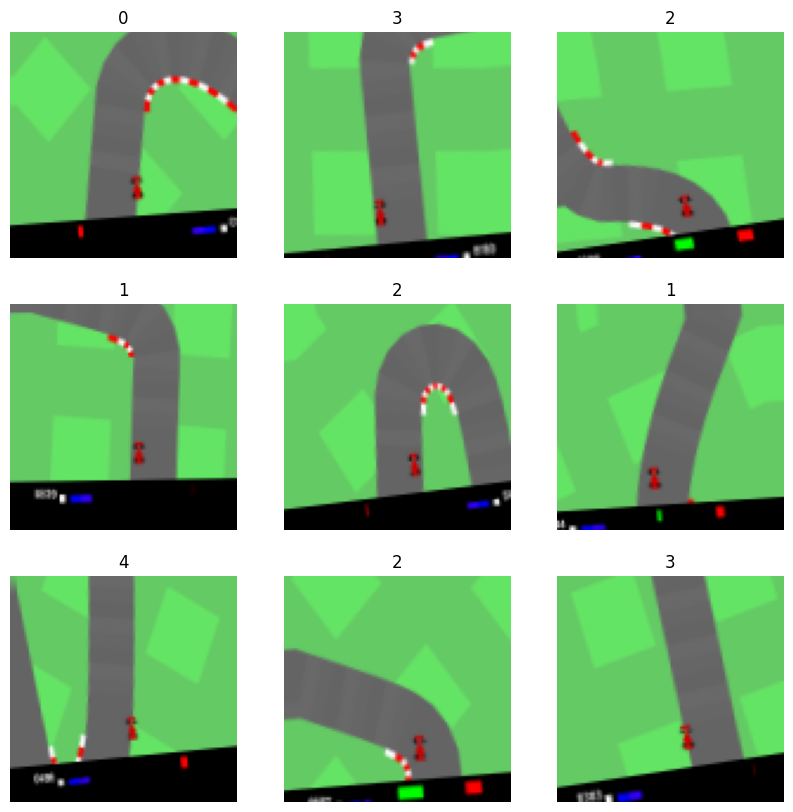

In [85]:
#Show some samples from the training dataset

import matplotlib.pyplot as plt

sample_images, sample_labels = next(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(min(9, batch_size)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(classnames[sample_labels[i].argmax()])
    plt.axis("off")
plt.show()


In [86]:
#Create the model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras import regularizers
from keras import optimizers

def CarNet(input_shape, num_classes):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=15, input_shape=input_shape, kernel_size=(5,5), dilation_rate=2, activation='relu'))

    # C2 Convolutional Layer
    model.add(Conv2D(filters=20, kernel_size=(5,5), dilation_rate=2, activation= 'relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))

    # C3 Convolutional Layer
    model.add(Conv2D(filters=30, kernel_size=(5,5), dilation_rate=2, activation= 'relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=40, kernel_size=(3,3), dilation_rate=2, activation= 'relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model.add(Flatten())

    # D1 Dense Layer
    model.add(Dense(128, activation='relu'))
    # Dropout
    model.add(Dropout(0.4))
    # D2 Dense Layer
    model.add(Dense(96, activation='relu'))
    # Dropout
    model.add(Dropout(0.4))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    optimizer = optimizers.RMSprop(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [87]:
#Initialize the model
model = CarNet(input_shape,num_classes)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 88, 88, 15)        1140      
                                                                 
 conv2d_22 (Conv2D)          (None, 80, 80, 20)        7520      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 40, 40, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 30)        15030     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 30)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 12, 12, 40)       

In [88]:
#Train the model
from sklearn.utils.class_weight import compute_class_weight

steps_per_epoch=train_dataset.n//train_dataset.batch_size
val_steps=validation_dataset.n//validation_dataset.batch_size+1

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_dataset.classes), y=train_dataset.classes)

try:
    history = model.fit(train_dataset, epochs=30,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=val_steps,
                    class_weight=dict(enumerate(class_weights)))
except KeyboardInterrupt:
    pass

Epoch 1/30
69/69 [==============================] - 39s 552ms/step - loss: 1.6114 - accuracy: 0.1977 - val_loss: 1.6093 - val_accuracy: 0.2068
Epoch 2/30
69/69 [==============================] - 37s 534ms/step - loss: 1.6074 - accuracy: 0.1784 - val_loss: 1.6105 - val_accuracy: 0.1817
Epoch 3/30
69/69 [==============================] - 37s 529ms/step - loss: 1.6035 - accuracy: 0.2243 - val_loss: 1.6003 - val_accuracy: 0.3225
Epoch 4/30
69/69 [==============================] - 36s 521ms/step - loss: 1.6012 - accuracy: 0.2537 - val_loss: 1.5916 - val_accuracy: 0.3503
Epoch 5/30
69/69 [==============================] - 36s 525ms/step - loss: 1.5956 - accuracy: 0.2899 - val_loss: 1.5767 - val_accuracy: 0.3623
Epoch 6/30
69/69 [==============================] - 36s 521ms/step - loss: 1.5821 - accuracy: 0.3149 - val_loss: 1.5580 - val_accuracy: 0.3921
Epoch 7/30
69/69 [==============================] - 36s 528ms/step - loss: 1.5711 - accuracy: 0.3395 - val_loss: 1.5396 - val_accuracy: 0.4073

In [89]:
#Evaluate the model
val_steps=test_dataset.n//test_dataset.batch_size+1
loss, acc = model.evaluate_generator(test_dataset,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

/tmp/ipykernel_3117/1112641325.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_dataset,steps=val_steps)


Test loss: 1.392143
Test accuracy: 0.644598


In [90]:
#Save the model
model.save("Model2.keras")

In [91]:
#Evaluate the model also with report and tables:

import sklearn.metrics
from sklearn.metrics import classification_report

preds = model.predict_generator(test_dataset, steps=val_steps)
y_pred = np.argmax(preds, axis=1)
y_test = test_dataset.classes

print(classification_report(y_test, y_pred, labels=None, target_names= classnames, digits=3))

/tmp/ipykernel_3117/2562616873.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_dataset, steps=val_steps)


              precision    recall  f1-score   support

           0      0.238     0.218     0.227       133
           1      0.248     0.367     0.296       275
           2      0.414     0.350     0.379       406
           3      0.816     0.787     0.801      1896
           4      0.152     0.179     0.165        39

    accuracy                          0.645      2749
   macro avg      0.373     0.380     0.374      2749
weighted avg      0.662     0.645     0.652      2749


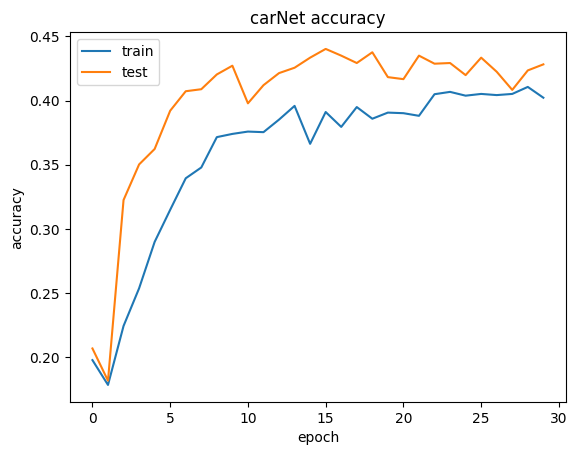

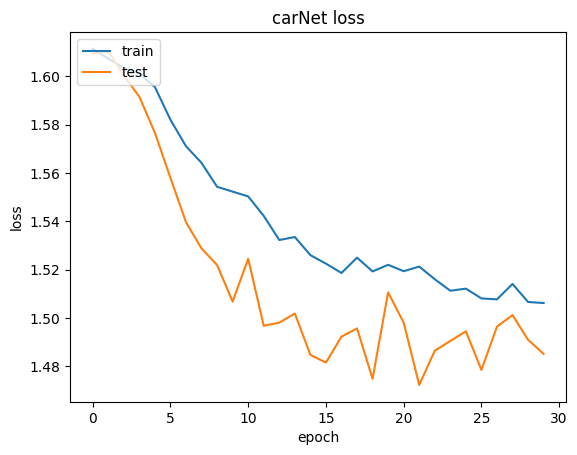

In [92]:
import matplotlib.pyplot as plt
def history_tab(history, name):
    
    #accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    #loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
history_tab(history, "carNet")